In [15]:
import os
import pickle
import sys

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
from copy import deepcopy
from PIL import Image
import matplotlib.patches as patches
from webbpsf import roman
from skimage import restoration
from astropy import convolution

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf

In [16]:
output_dir = os.path.join(array_dir, 'scenes_across_detectors')
util.create_directory_if_not_exists(output_dir)

In [17]:
lens = SampleSkyPyStrongLens()

num_pix = 45
side = 4.95
band = 'f184'
supersample_factor = 3
num_samples = 100000

# add CDM subhalos
lens.add_subhalos(*pyhalo.generate_CDM_halos(lens.z_lens, lens.z_source, cone_opening_angle_arcsec=6.))

model = lens.get_array(num_pix=51 * supersample_factor, side=5.61)

In [18]:
execute = False

if execute:
    calc, _ = pandeia_input.build_pandeia_calc(model, lens, background=False, band=band, max_scene_size=5, noise=False, num_samples=num_samples, suppress_output=False)
    pandeia_off, _ = pandeia_input.get_pandeia_image(calc, suppress_output=False)
    np.save(os.path.join(output_dir, 'pandeia_off.npy'), pandeia_off)
    
    calc, _ = pandeia_input.build_pandeia_calc(model, lens, background=True, band=band, max_scene_size=5, noise=True, num_samples=num_samples, suppress_output=False)
    pandeia_on, _ = pandeia_input.get_pandeia_image(calc)
    np.save(os.path.join(output_dir, 'pandeia_on.npy'), pandeia_on)
else:
    print('Loading pre-computed images')

Loading pre-computed images


In [19]:
pandeia_off = np.load(os.path.join(output_dir, 'pandeia_off.npy'))
pandeia_on = np.load(os.path.join(output_dir, 'pandeia_on.npy'))

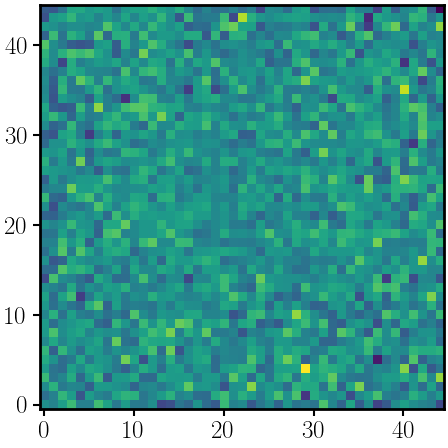

In [20]:
noise_and_convolved_bkg = pandeia_on - pandeia_off

plt.imshow(noise_and_convolved_bkg)

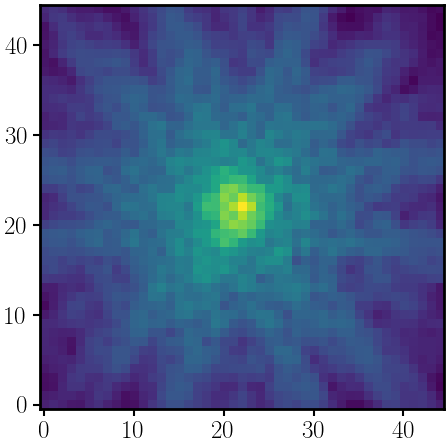

In [21]:
wfi = roman.WFI()
wfi.filter = 'F184'
calc_psf = wfi.calc_psf(oversample=supersample_factor)
pandeia_kernel = psf.get_kernel_from_calc_psf(calc_psf)

plt.imshow(np.log10(pandeia_kernel))

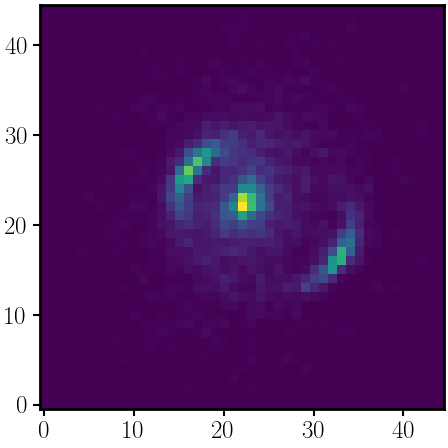

In [22]:
deconvolved = restoration.richardson_lucy(pandeia_off, pandeia_kernel, num_iter=30, clip=False)

plt.imshow(deconvolved)

Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the ran

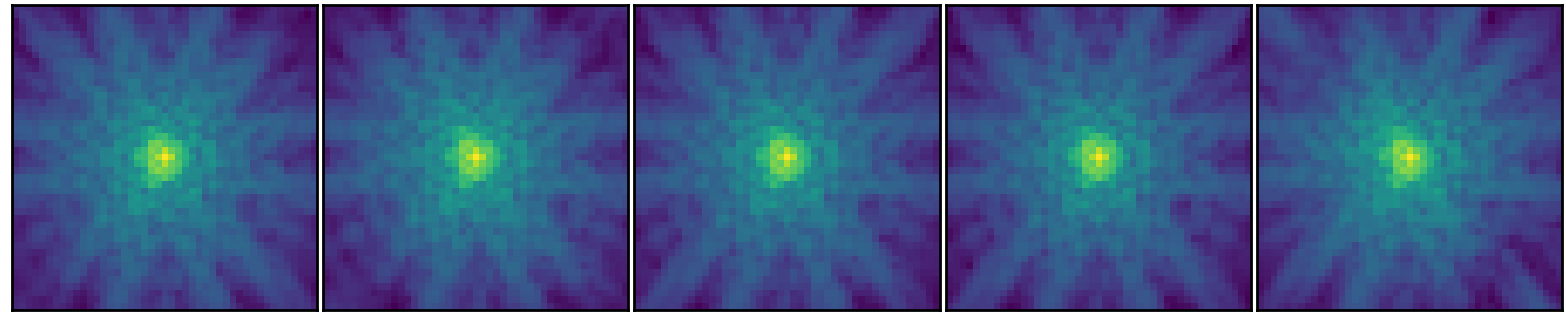

In [36]:
# get kernels
wfi_05 = roman.WFI()
wfi_05.filter = 'F184'
wfi_05.detector = 'SCA05'
wfi_05.detector_position = (1024, 3072)
calc_psf_05 = wfi_05.calc_psf(oversample=supersample_factor)
kernel_sca05 = psf.get_kernel_from_calc_psf(calc_psf_05)

wfi_09 = roman.WFI()
wfi_09.filter = 'F184'
wfi_09.detector = 'SCA09'
wfi_09.detector_position = (4, 4)
calc_psf_09 = wfi_09.calc_psf(oversample=supersample_factor)
kernel_sca09 = psf.get_kernel_from_calc_psf(calc_psf_09)

wfi_11 = roman.WFI()
wfi_11.filter = 'F184'
# wfi_11.detector = 'SCA10'
# wfi_11.detector_position = (4, 1024)
wfi_11.detector = 'SCA11'
wfi_11.detector_position = (4, 4092)
calc_psf_11 = wfi_11.calc_psf(oversample=supersample_factor)
kernel_sca11 = psf.get_kernel_from_calc_psf(calc_psf_11)

wfi_15 = roman.WFI()
wfi_15.filter = 'F184'
wfi_15.detector = 'SCA12'
wfi_15.detector_position = (3072, 1024)
calc_psf_15 = wfi_15.calc_psf(oversample=supersample_factor)
kernel_sca15 = psf.get_kernel_from_calc_psf(calc_psf_15)

wfi_16 = roman.WFI()
wfi_16.filter = 'F184'
wfi_16.detector = 'SCA16'
wfi_16.detector_position = (4092, 4092)
calc_psf_16 = wfi_16.calc_psf(oversample=supersample_factor)
kernel_sca16 = psf.get_kernel_from_calc_psf(calc_psf_16)

plot.plot_list([np.log10(kernel_sca05), np.log10(kernel_sca09), np.log10(kernel_sca11), np.log10(kernel_sca15), np.log10(kernel_sca16)])

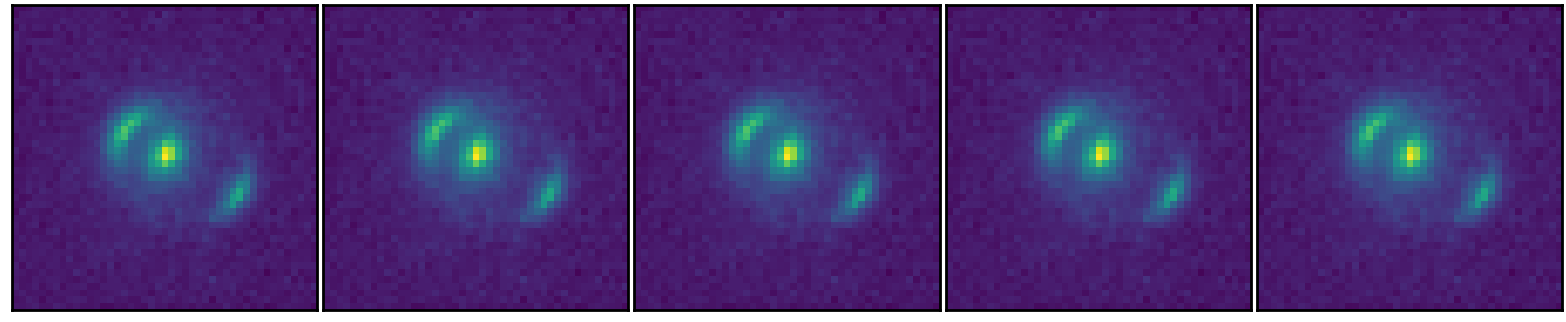

In [37]:
image_05 = convolution.convolve(deconvolved, kernel_sca05)
image_09 = convolution.convolve(deconvolved, kernel_sca09)
image_11 = convolution.convolve(deconvolved, kernel_sca11)
image_15 = convolution.convolve(deconvolved, kernel_sca15)
image_16 = convolution.convolve(deconvolved, kernel_sca16)

image_05 += noise_and_convolved_bkg
image_09 += noise_and_convolved_bkg
image_11 += noise_and_convolved_bkg
image_15 += noise_and_convolved_bkg
image_16 += noise_and_convolved_bkg

plot.plot_list([image_05, image_09, image_11, image_15, image_16])

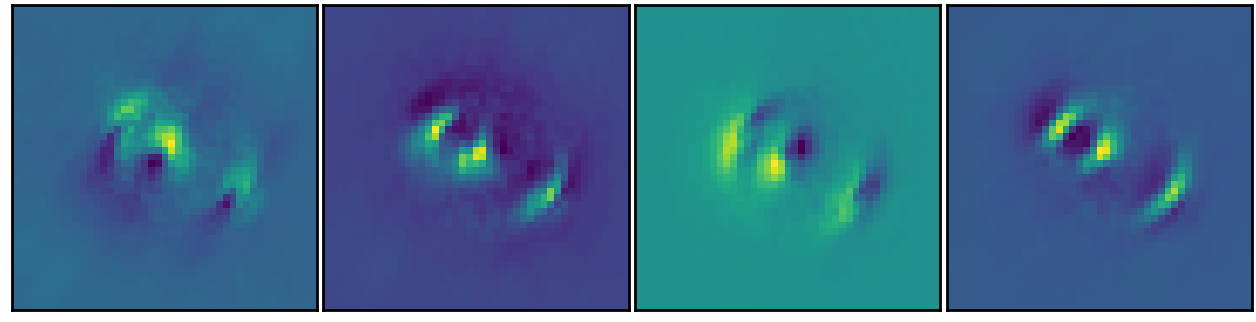

In [38]:
residual_05 = image_11 - image_05
residual_09 = image_11 - image_09
residual_15 = image_11 - image_15
residual_16 = image_11 - image_16

residual_list = [residual_05, residual_09, residual_15, residual_16]

plot.plot_list(residual_list)

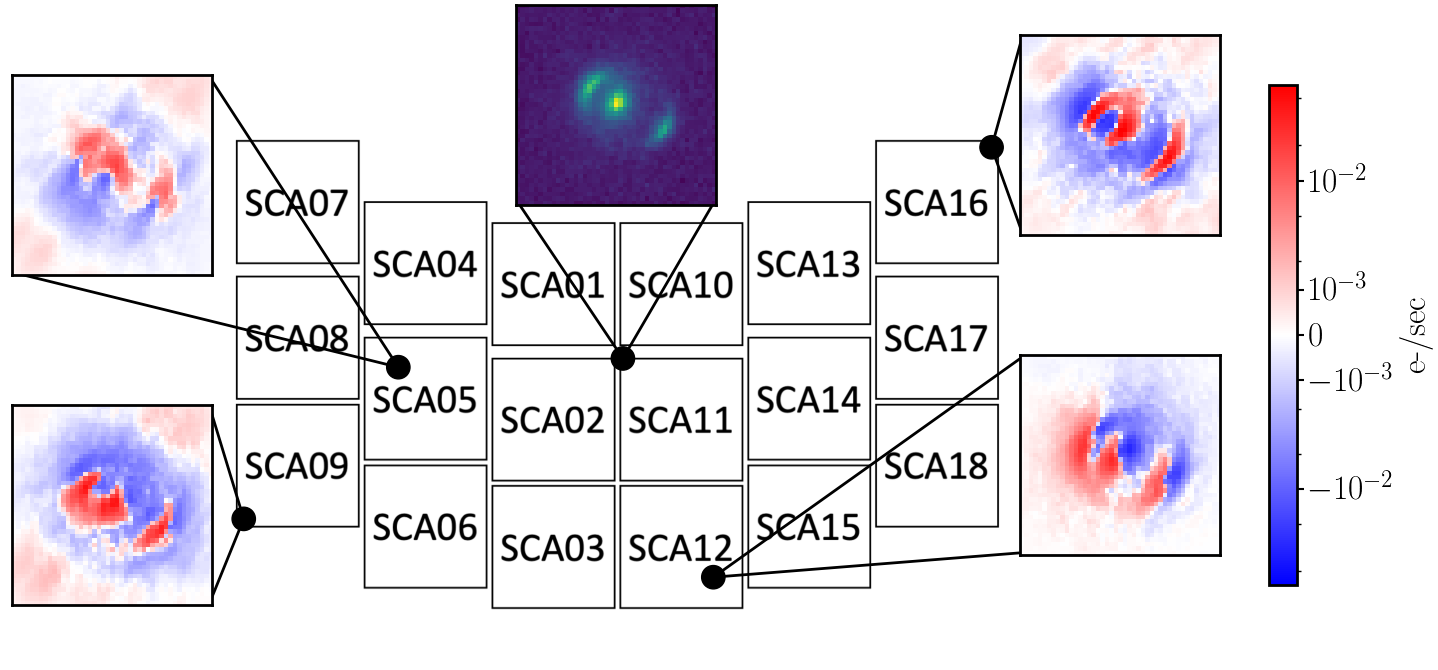

In [45]:
f, ax = plt.subplots(figsize=(14, 10))

fontsize = 24
matplotlib.rcParams.update({'font.size': fontsize})

fov = np.asarray(Image.open('../graphics/roman_fov.png'))
ax.imshow(fov, origin='upper')
ax.set_axis_off()

vmin, vmax = -0.05, 0.05  # vmin=vmin, vmax=vmax
norm = plot_util.get_norm(residual_list, linear_width=0.001)

circ_05_coords = (535, 535)
circ_05 = patches.Circle(circ_05_coords, radius=20, color='black')
point_05 = ax.add_patch(circ_05)
ax_05 = f.add_axes([0.015,0.58,0.2,0.2], anchor='NE', zorder=1)
im = ax_05.imshow(residual_05, cmap='bwr', norm=norm)
ax_05.spines[:].set_linewidth(2.)
ax_05.set_xticks([])
ax_05.set_yticks([])
con_05_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_b.set_linewidth(2)
con_05_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_t.set_linewidth(2)
ax.add_artist(con_05_b)
ax.add_artist(con_05_t)

circ_09_coords = (270, 795)
circ_09 = patches.Circle(circ_09_coords, radius=20, color='black')
point_09 = ax.add_patch(circ_09)
ax_09 = f.add_axes([0.015,0.25,0.2,0.2], anchor='NE', zorder=1)
ax_09.imshow(residual_09, cmap='bwr', norm=norm)
ax_09.spines[:].set_linewidth(2.)
ax_09.set_xticks([])
ax_09.set_yticks([])
con_09_b = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_b.set_linewidth(2)
con_09_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_t.set_linewidth(2)
ax.add_artist(con_09_b)
ax.add_artist(con_09_t)

circ_11_coords = (920, 520)
circ_11 = patches.Circle(circ_11_coords, radius=20, color='black')
point_11 = ax.add_patch(circ_11)
ax_11 = f.add_axes([0.375,0.65,0.2,0.2], anchor='NE', zorder=1)
ax_11.imshow(image_11, cmap='viridis')
ax_11.spines[:].set_linewidth(2.)
ax_11.set_xticks([])
ax_11.set_yticks([])
con_11_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_b.set_linewidth(2)
con_11_t = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_t.set_linewidth(2)
ax.add_artist(con_11_b)
ax.add_artist(con_11_t)

circ_15_coords = (1075, 895)
circ_15 = patches.Circle(circ_15_coords, radius=20, color='black')
point_15 = ax.add_patch(circ_15)
ax_15 = f.add_axes([0.735,0.3,0.2,0.2], anchor='NE', zorder=1)
ax_15.imshow(residual_15, cmap='bwr', norm=norm)
ax_15.spines[:].set_linewidth(2.)
ax_15.set_xticks([])
ax_15.set_yticks([])
con_15_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_15.transData, xyB=circ_15_coords, coordsB=ax.transData)
con_15_b.set_linewidth(2)
con_15_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_15.transData, xyB=circ_15_coords, coordsB=ax.transData)
con_15_t.set_linewidth(2)
ax.add_artist(con_15_b)
ax.add_artist(con_15_t)

circ_16_coords = (1552, 158)
circ_16 = patches.Circle(circ_16_coords, radius=20, color='black')
point_16 = ax.add_patch(circ_16)
ax_16 = f.add_axes([0.735,0.62,0.2,0.2], anchor='NE', zorder=1)
ax_16.imshow(residual_16, cmap='bwr', norm=norm)
ax_16.spines[:].set_linewidth(2.)
ax_16.set_xticks([])
ax_16.set_yticks([])
con_16_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_b.set_linewidth(2)
con_16_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_t.set_linewidth(2)
ax.add_artist(con_16_b)
ax.add_artist(con_16_t)

cax = f.add_axes([0.97, 0.27, 0.02, 0.5])
cbar = f.colorbar(im, cax=cax, ticks=[-10** -2, -10** -3, 0, 10 ** -3, 10 ** -2])
cbar.set_label('e-/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'scenes_across_detectors.png'))
plt.show()